# Easy DEM

In [19]:

import glob
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
import rioxarray  # activate the rio accessor

import hvplot.xarray
import pyproj as ppj

#import cartopy
import cartopy.crs as ccrs
#import cartopy.feature as cfeature
#import locale
#locale.setlocale(locale.LC_ALL, 'en_US.utf8')
import matplotlib.pyplot as plt
import matplotlib as mpl
#mpl.use('TkAgg')

import panel as pn

from suncalc import get_position, get_times
from datetime import datetime
import grstbx
from grstbx import visual

u = grstbx.utils
opj = os.path.join

print(f'-grstbx: {grstbx.__version__}')

-grstbx: 2.0.2


## Get DEM file

In [2]:
tile = '31TFJ'
dem_file = '/home/harmel/Dropbox/Dropbox/satellite/dem/COP-DEM_GLO-30-DGED_'+tile+'.tif'

In [11]:
dem = xr.open_dataarray(dem_file).squeeze()

In [12]:
dem



<xarray.DataArray 'band_data' (y: 5490, x: 5490)>
[30140100 values with dtype=float32]
Coordinates:
    band         int64 1
  * x            (x) float64 6e+05 6e+05 6e+05 ... 7.098e+05 7.098e+05 7.098e+05
  * y            (y) float64 4.9e+06 4.9e+06 4.9e+06 ... 4.79e+06 4.79e+06
    spatial_ref  int64 ...
Attributes:
    AREA_OR_POINT:  Area

In [32]:
lonmin,latmin,lonmax,latmax = dem.rio.transform_bounds(4326)
clon, clat = np.mean([lonmin,lonmax]),np.mean([latmin,latmax])
clon,clat

(4.929339336868338, 43.74107594709233)

In [14]:
str_epsg = str(dem.rio.crs)
zone = str_epsg[-2:]
is_south = str_epsg[2] == 7
proj = ccrs.UTM(zone, is_south)

In [38]:
date = datetime.strptime('2023-01-01T12:30','%Y-%m-%dT%H:%M')

In [39]:
date

datetime.datetime(2023, 1, 1, 12, 30)

sunpos = get_position(date, clon, clat)

Returns an object with the following properties:

- altitude: sun altitude above the horizon in radians, e.g. 0 at the horizon and PI/2 at the zenith (straight over your head)
- azimuth: sun azimuth in radians (direction along the horizon, measured from south to west), e.g. 0 is south and Math.PI * 3/4 is northwest


In [40]:


sunpos = get_position(date, clon, clat)

In [43]:
date.strftime('%Y-%m-%d')

'2023-01-01'

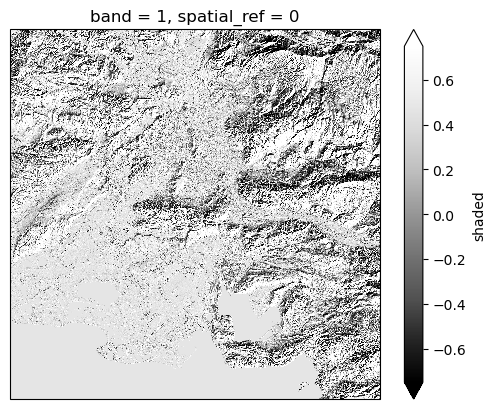

In [61]:
date.strftime('%Y-%m-%d')
sunpos = get_position(date, clon, clat)
sza=90-np.degrees(sunpos['altitude'])
azi=(np.degrees(sunpos['azimuth'])-180 ) %360

dem_attrs = grstbx.dem.compute_dem_attributes(dem,sza,azi)
dem_attrs.shaded.plot.imshow(robust=True,subplot_kws=dict(projection=proj),cmap=plt.cm.Greys_r,vmax=0.75)#,add_colorbar=False)#,cbar_kwargs={'shrink':0.4})

In [57]:
azi

159.67469154171462

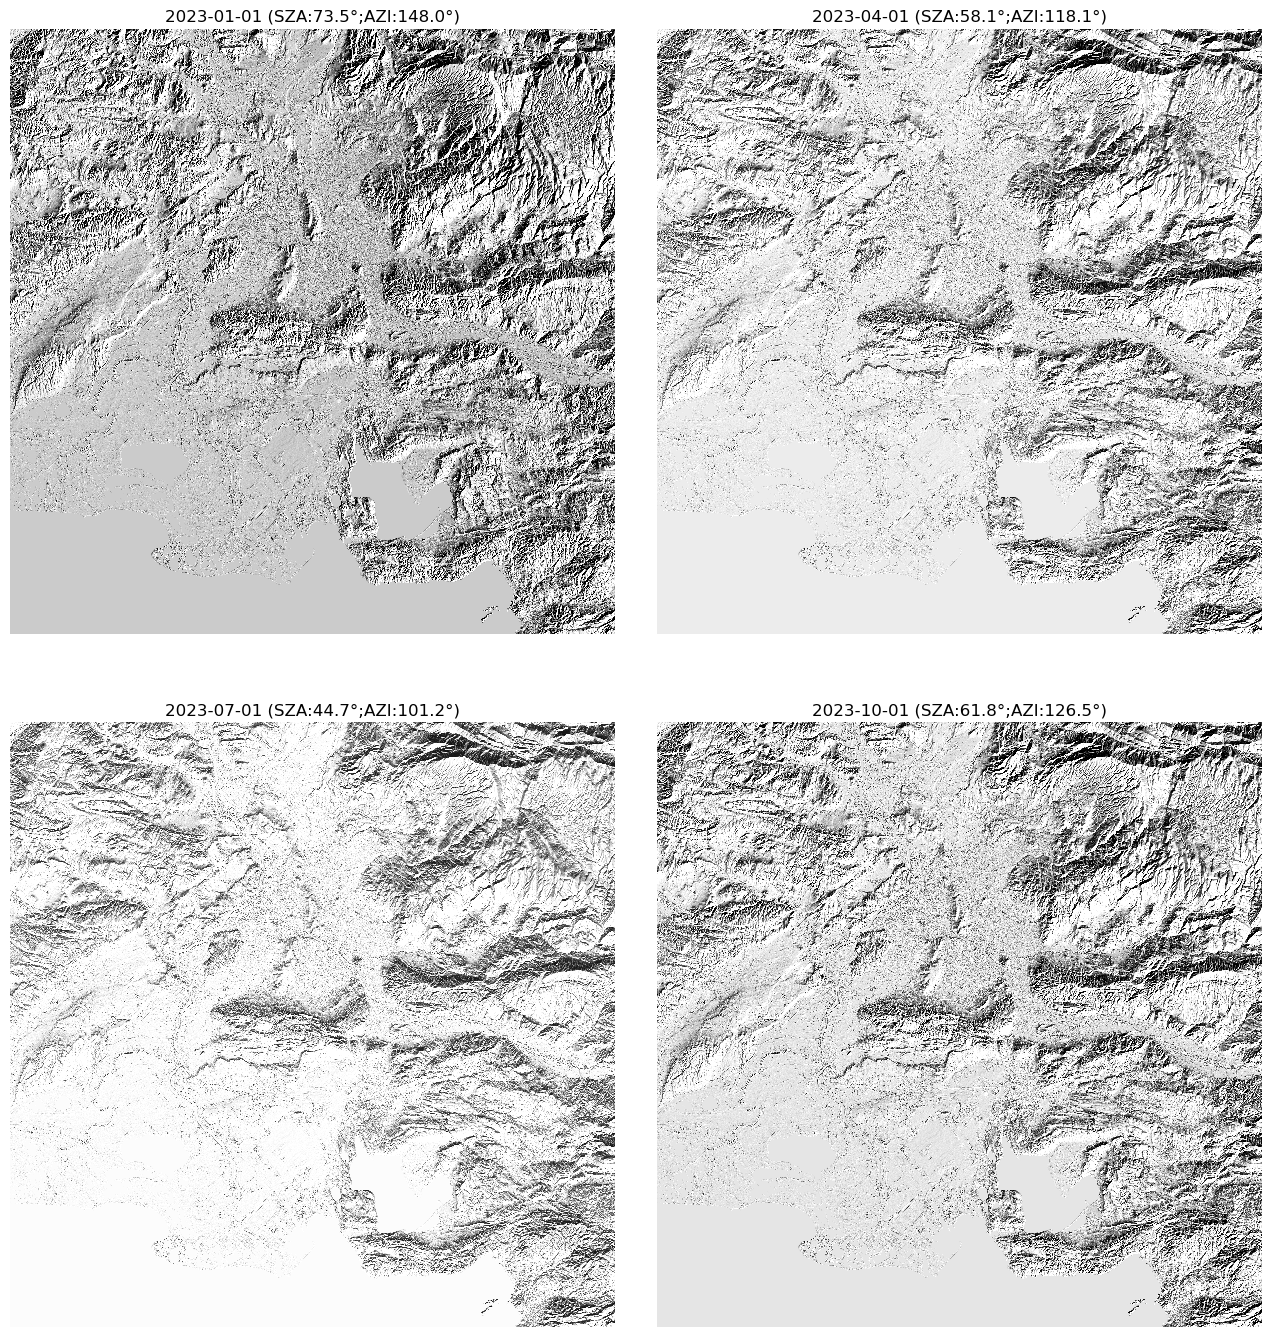

In [60]:
ncols=2

months= [1,4,7,10]

Ndates = len(months)
ncols=np.min([ncols,Ndates])
nrows=int(np.ceil(Ndates/ncols))    

fig,axs = plt.subplots(nrows,ncols,figsize=(ncols*7,7*nrows+2.5),subplot_kw={'projection': proj}) 
fig.subplots_adjust(bottom=0.08, top=0.9, left=0.086, right=0.98,
                    hspace=0.05, wspace=0.07,)
if (ncols == 1) & (nrows == 1):
    axs = np.array([axs])
axs=axs.ravel()
[axi.set_axis_off() for axi in axs]


for ii,month in enumerate(months):
    date = datetime.strptime('2023-{:02d}-01T10:30'.format(month),'%Y-%m-%dT%H:%M')
    date_ = date.strftime('%Y-%m-%d')
    sunpos = get_position(date, clon, clat)
    sza=90-np.degrees(sunpos['altitude'])
    azi=(np.degrees(sunpos['azimuth'])-180 ) %360
    
    dem_attrs = grstbx.dem.compute_dem_attributes(dem,sza,azi)
    dem_attrs.shaded.plot.imshow(ax=axs[ii],robust=True,cmap=plt.cm.Greys_r,vmax=0.75,add_colorbar=False)#,cbar_kwargs={'shrink':0.4})
   
    axs[ii].set_title(date_+' (SZA:{:.1f}°;AZI:{:.1f}°)'.format(sza,azi))